In [ ]:
# INSTALAÇÃO DAS BIBLIOTECAS NECESSÁRIAS
%pip install pandas openai sentence-transformers networkx matplotlip pymupd

In [1]:
# IMPORTAÇÃO DAS BIBLIOTECAS

import json
import logging
import os
import time
import fitz
import matplotlib.pyplot as plt
import networkx as nx
from openai import OpenAI
import pandas as pd
from sentence_transformers import SentenceTransformer, util

CV_Folder = "CVs" #NOME DA PASTA ONDE OS CVs EM FORMATO PDF ESTÃO ARMAZENADOS

In [2]:

# Define a decorator to measure the execution time of functions
def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"  - tempo de operação {end_time - start_time:.1f}s")
        return result
    return wrapper


In [3]:
# Definição da ontologia

# Tipos de entidades ou nós:
entity_types = {
  "person": { "type": "string" }, 
  "company": { "type": "string" },
  "position": { "type": "string" }, 
  "achievement": { "type": "string" },
  "place": { "type": "string" }, 
  "language": { "type": "string" }, 
  "school or university": { "type": "string" },
  "technology": { "type": "string" },
  "skill": { "type": "string" }
}

# Tipos de relacionamentos:
relation_types = {
  "worked as": { "type": "string" }, 
  "studied at": { "type": "string" }, 
  "has achieved": { "type": "string" },
  "is located at": { "type": "string" }, 
  "speaks or understands": { "type": "string" }, 
  "has studied": { "type": "string" },
  "has worked for": { "type": "string" },
  "has skill": { "type": "string" }
 }

In [4]:
# Chave para acesso ao API da OepnAI
client = OpenAI(api_key="PLEAS USE YOUR OWN!!")

# Chamada ao GPT 3.5 Turbo
@timeit
def extract_information(text, model="gpt-3.5-turbo"):
   completion = client.chat.completions.create(
        model=model, # Gpt 3.5 é um excelente custo beneficio para este uso
        temperature=0, # Não queremos criatividade, apenas análise semântica
        messages=[
        {
            "role": "system",
            "content": system_prompt # Parâmetro para prompt
        },
        {
            "role": "user",
            "content": user_prompt.format(
              entity_types=entity_types,
              relation_types=relation_types,
              specification=text
            ) # Parâmetros para composição do prompt
        }
        ]
    )

   return completion.choices[0].message.content, completion.usage.total_tokens

# Definição da função do assitente
system_prompt = """You are an expert agent specialized in analyzing curiculum vitae.
Your task is to identify the entities and relations requested with the user prompt, from a given aplicant.
You must generate the output in a JSON containing a list with JOSN objects having the following keys: "head", "head_type", "relation", "tail", and "tail_type".
The "head" key must contain the text of the extracted entity with one of the types from the provided list in the user prompt, the "head_type"
key must contain the type of the extracted head entity which must be one of the types from the provided user list,
the "relation" key must contain the type of relation between the "head" and the "tail", the "tail" key must represent the text of an
extracted entity which is the tail of the relation, and the "tail_type" key must contain the type of the tail entity. Attempt to extract as
many entities and relations as you can. And remember to translate entities to english, whenever some other language is used.
"""

# Definição da estrutura do prompt
user_prompt = """Based on the following example, extract entities and relations from the provided text.
Use the following entity types:

# ENTITY TYPES:
{entity_types}

Use the following relation types:
{relation_types}

--> Beginning of example

# Specification
"MARISA MONTE DOS MONTES \nControl and Automation Engineer \nWorkforce & Business Excellence \n \nProject Engineer at Siemens with 5+ years of experience in a global corporate. Skilled Business Excellence and resource availability \nmanagement agent with effective communication and management skills, with ability on distinct roles: Sales Operations, \nimplementation and maintenance of the Quality Management System and Management support on ADMS bids. \n \nWORK EXPERIENCE \nSiemens Brazil \nProject Engineer II \n \n \nAnalysis and planning of resource availability on complex projects considering risks \nlinked to allocation.  \nApplication of authoring method that aims ranking and prioritizing the implementation \nof projects. \nContinuous process improvement. \nProvision of valuable information to Business Excellence and Sales Operations in a \nnational and global matter. \nImplementation and maintenance of the Quality Management System and for the \nelaboration, verification, and coordination of process-oriented systems, including the \nidentification and implementation of improvements, to ensure the continuous \nenhancement of the quality management, in line with the established strategies. \nBid Technical Support\n \nManagement support on ADMS bids (one of which we were awarded), discussing \nrequirements internally with the team and with the customer, supporting estimating \ncosts and timeline, elaborating documentation, and contacting suppliers. Assisted \nProject Managers to ensure schedule and costs were met. Continuously finding and \nimproving processes. \nResponsible for training and administering, countrywide, the E2E browser-based \nsystem for managing bid requirements that allows integration between analysts, \nengineers, quality team members, sales, project managers and DevOps. \n \nOTHER \n \nIdeasRanker \nAuthoring method that aims ranking and easing choosing projects. \n \nScience Without Borders (Ciência Sem Fronteiras - CsF) \nOne year of Automation and Robotics Engineering in University of Pisa (Italy). \n \nActive member of Innovation Committee at Siemens \nSince 2018. \nSKILLS \n \nTechnical \nAgile \nJira \nMs Project \nOrbit* / Tableau \nPower BI  \nPolarion*: End-to-End – Requirements \nManagement \n* Siemens internal \nProfessional \nEffective Communication \nHighly organized \nInitiative-taking and dependable \nLeadership \nResult-driven \n \n \nEDUCATION \n \nMaster of Business Administration – \nMBA, Agile Project Management in \nEngineering and Industry 4.0 \nPontifical Catholic University of Paraná \n \nControl and Automation Engineer \nFederal Technological University of \nParaná \n \n \nLANGUAGES \n \nPortuguese (Native) \nEnglish (Advanced) \nItalian (Advanced) \nFrench (Beginner) \n \n \nJanuary 2018 – August 2022 \nFebruary 2020 - Current \n \n+55 41 999801805 \n \nleticiadegg@gmail.com \n \nlinkedin.com/in/leticiagraziano/ \n Brazil, Curitiba \n \n"

################

# Output
[
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "worked as",
    "tail": "Control and Automation Engineer",
    "tail_type": "position"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "worked as",
    "tail": "Workforce & Business Excellence",
    "tail_type": "position"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has worked for",
    "tail": "Siemens",
    "tail_type": "company"
  }},
  {{
    "head": "Siemens",
    "head_type": "company",
    "relation": "is located at",
    "tail": "Brazil",
    "tail_type": "place"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "worked as",
    "tail": "Project Engineer II",
    "tail_type": "position"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has achieved",
    "tail": "Analysis and planning of resource availability on complex projects considering risks linked to allocation.",
    "tail_type": "achievement"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has achieved",
    "tail": "Application of authoring method that aims ranking and prioritizing the implementation of projects",
    "tail_type": "achievement"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has achieved",
    "tail": "Continuous process improvement",
    "tail_type": "achievement"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has achieved",
    "tail": "Provision of valuable information to Business Excellence and Sales Operations in a national and global matter.",
    "tail_type": "achievement"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has achieved",
    "tail": "Implementation and maintenance of the Quality Management System and for the elaboration, verification, and coordination of process-oriented systems, including the identification and implementation of improvements, to ensure the continuous enhancement of the quality management, in line with the established strategies.",
    "tail_type": "achievement"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "speaks or understands",
    "tail": "Portuguese",
    "tail_type": "language"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "speaks or understands",
    "tail": "English",
    "tail_type": "language"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "speaks or understands",
    "tail": "Italian",
    "tail_type": "language"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has skill",
    "tail": "Management",
    "tail_type": "language"
  }}
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has skill",
    "tail": "Agile",
    "tail_type": "language"
  }}
]

--> End of example

For the following specification, generate extract entitites and relations as in the provided example.

# Specification
{specification}
################

# Output

"""

In [5]:
#find first '[' and last ']' in string
# Esta função apenas verifica se o GPT retornou uma lista ou um text, transformando texto para lista
def find_brackets(string):
    first = 0
    for i in range(len(string)):
        if string[i] == '[' and first==0:
            first = i
        if string[i] == ']':
            last = i
    return first, last

# transform text to json
def text_to_json(text):
    json_data = json.loads(text)
    return json_data

def ajustar_output(output):
    if not isinstance(output, list):
        f, l = find_brackets(output)
        return text_to_json(output[f:l+1])
    return output


In [7]:
# Aqui executamos a ingestão da dados.
# Abrir PDF contido no diretório, extrair seus textos e chamar a função do GPT para a extração da informação

kg = []
pdf_files = [f for f in os.listdir(CV_Folder) if f.endswith('.pdf')]
for file in pdf_files:
    print("Parsing", file)
    with fitz.open(CV_Folder + "/" + file) as doc:  # open document
        cv = chr(12).join([page.get_text() for page in doc])
    try:
        extracted_relations, tokens_used = extract_information(cv)
        extracted_relations = ajustar_output(extracted_relations)
        kg.extend(extracted_relations)
        print("  - Parsing OK -" + str(tokens_used) + " tokens consumidos")
    except Exception as e:
        print("  - ERRO")
        logging.error(e)


Parsing Antonio Fagundes CVi.pdf
  - tempo de operação 14.9s
  - Parsing OK -3227 tokens consumidos
Parsing CV Elis Regina.pdf
  - tempo de operação 17.0s
  - Parsing OK -3417 tokens consumidos
Parsing CV Joao Silva 2022.pdf
  - tempo de operação 9.2s
  - Parsing OK -3825 tokens consumidos
Parsing CV Maria Betânia at.pdf
  - tempo de operação 35.0s
  - Parsing OK -5147 tokens consumidos
Parsing CV Nicholas Arand EN - 2022.pdf
  - tempo de operação 26.0s
  - Parsing OK -4216 tokens consumidos
Parsing Raimundo Fagner.pdf
  - tempo de operação 17.6s
  - Parsing OK -4260 tokens consumidos


In [8]:
kg_relations = pd.DataFrame(kg)
kg_relations.to_csv("sixcvs.csv")

In [50]:
kg_relations = pd.read_csv("sixcvs.csv", index_col=0)

In [52]:
# identify pairs of tails with cos similarity above 0.95
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
def find_pairs(lista, th):
    pairs = []
    unicos = list(set(lista))
    embeddings = embedding_model.encode(unicos)
    for i in range(len(unicos)):
        for j in range(i + 1, len(unicos)):
            if util.cos_sim(embeddings[i], embeddings[j]) > th:
                pairs.append((unicos[i], unicos[j]))
    return pairs

pares = find_pairs(kg_relations['tail'].values, 0.8)
pares

[('Microsoft Power Automate', 'Power Automate'),
 ('Coordenadora de Produção e Qualidade',
  'Analista de desenvolvimento de produto'),
 ('Coordenadora de Produção e Qualidade', 'Gerente de Produção e Qualidade'),
 ('Analista de desenvolvimento de produto', 'Gerente de Produção e Qualidade'),
 ('Agile', 'Agile Methodologies'),
 ('MS Office', 'Microsoft Office Suite'),
 ('AutoCad', 'AutoCAD'),
 ('Universidade Federal do Paraná', 'Federal University of Paraná'),
 ('Universidade Federal do Paraná', 'Universidade de São Paulo')]

In [53]:
to_clean = [1, 0, 1, 0, 1, 1, 1, 1, 0]
# replace tail if is part of a pares
if len(to_clean) == len(pares):
    for par, test in zip(pares,to_clean):
        if test == 1:
            for i in range(len(kg_relations)):
                if kg_relations['tail'][i]==par[1]:
                    kg_relations.loc[i,'tail']=par[0]
else:
    print("Error: len(to_clean) != len(pares)")

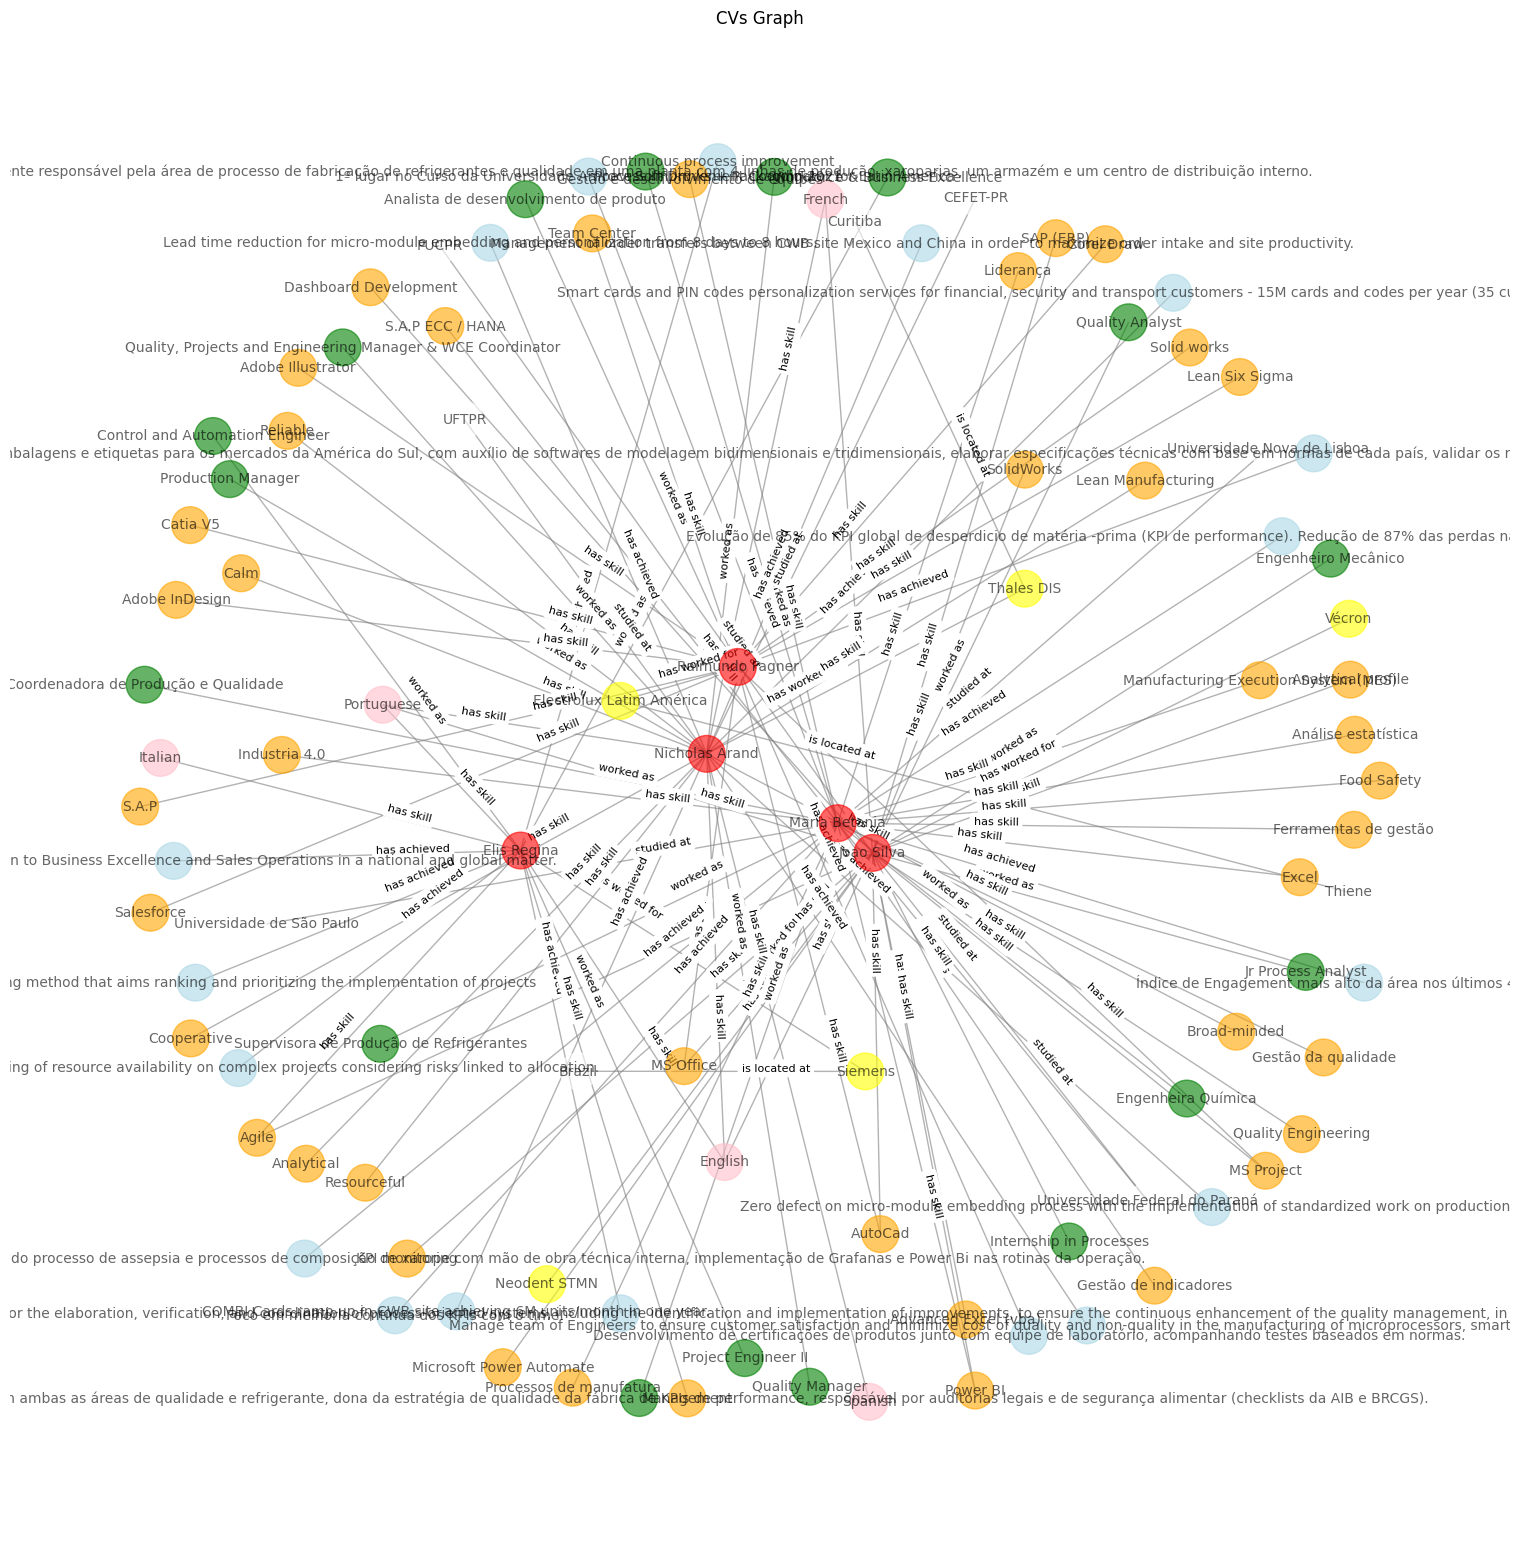

In [140]:
# Criação do Grafo
G = nx.Graph()
# Create nodes with atributes
for _, row in kg_relations.iterrows():
  #if node doesn't exist, create it
  if not G.has_node(row['head']):
    G.add_node(row['head'], type=row['head_type'])
  if not G.has_node(row['tail']):
    G.add_node(row['tail'], type=row['tail_type'])
#Create edges with labels
for _, row in kg_relations.iterrows():
  G.add_edge(row['head'], row['tail'], label=row['relation'])

# Impressão do grafo

# Definição das cores por nó
entity_color = {
  "person": "red", 
  "company": "yellow",
  "position": "green" , 
  "achievement": "lightblue" ,
  "place": "white", 
  "language": "pink", 
  "school or university": "white",
  "technology": "orange",
  "skill": "orange"
}
#Create index of colors for nodes by type
node_color = [entity_color[G.nodes[node]['type']] for node in G.nodes()]

# Impressao
pos = nx.spring_layout(G, seed=47, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color=node_color, edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('CVs Graph')
plt.show()

In [118]:
# FILTRAR POR ABILIDADES

filter_values = ['AutoCad', 'English', 'MS Office']
pass_list = kg_relations[kg_relations['tail'].isin(filter_values)]['head'].value_counts().keys()

show_flag = []
for _, row in kg_relations.iterrows():
    if row['tail'] in  filter_values:
        show_flag.append(1)
    else:
        show_flag.append(0)

kg_relations['show_flag'] = show_flag

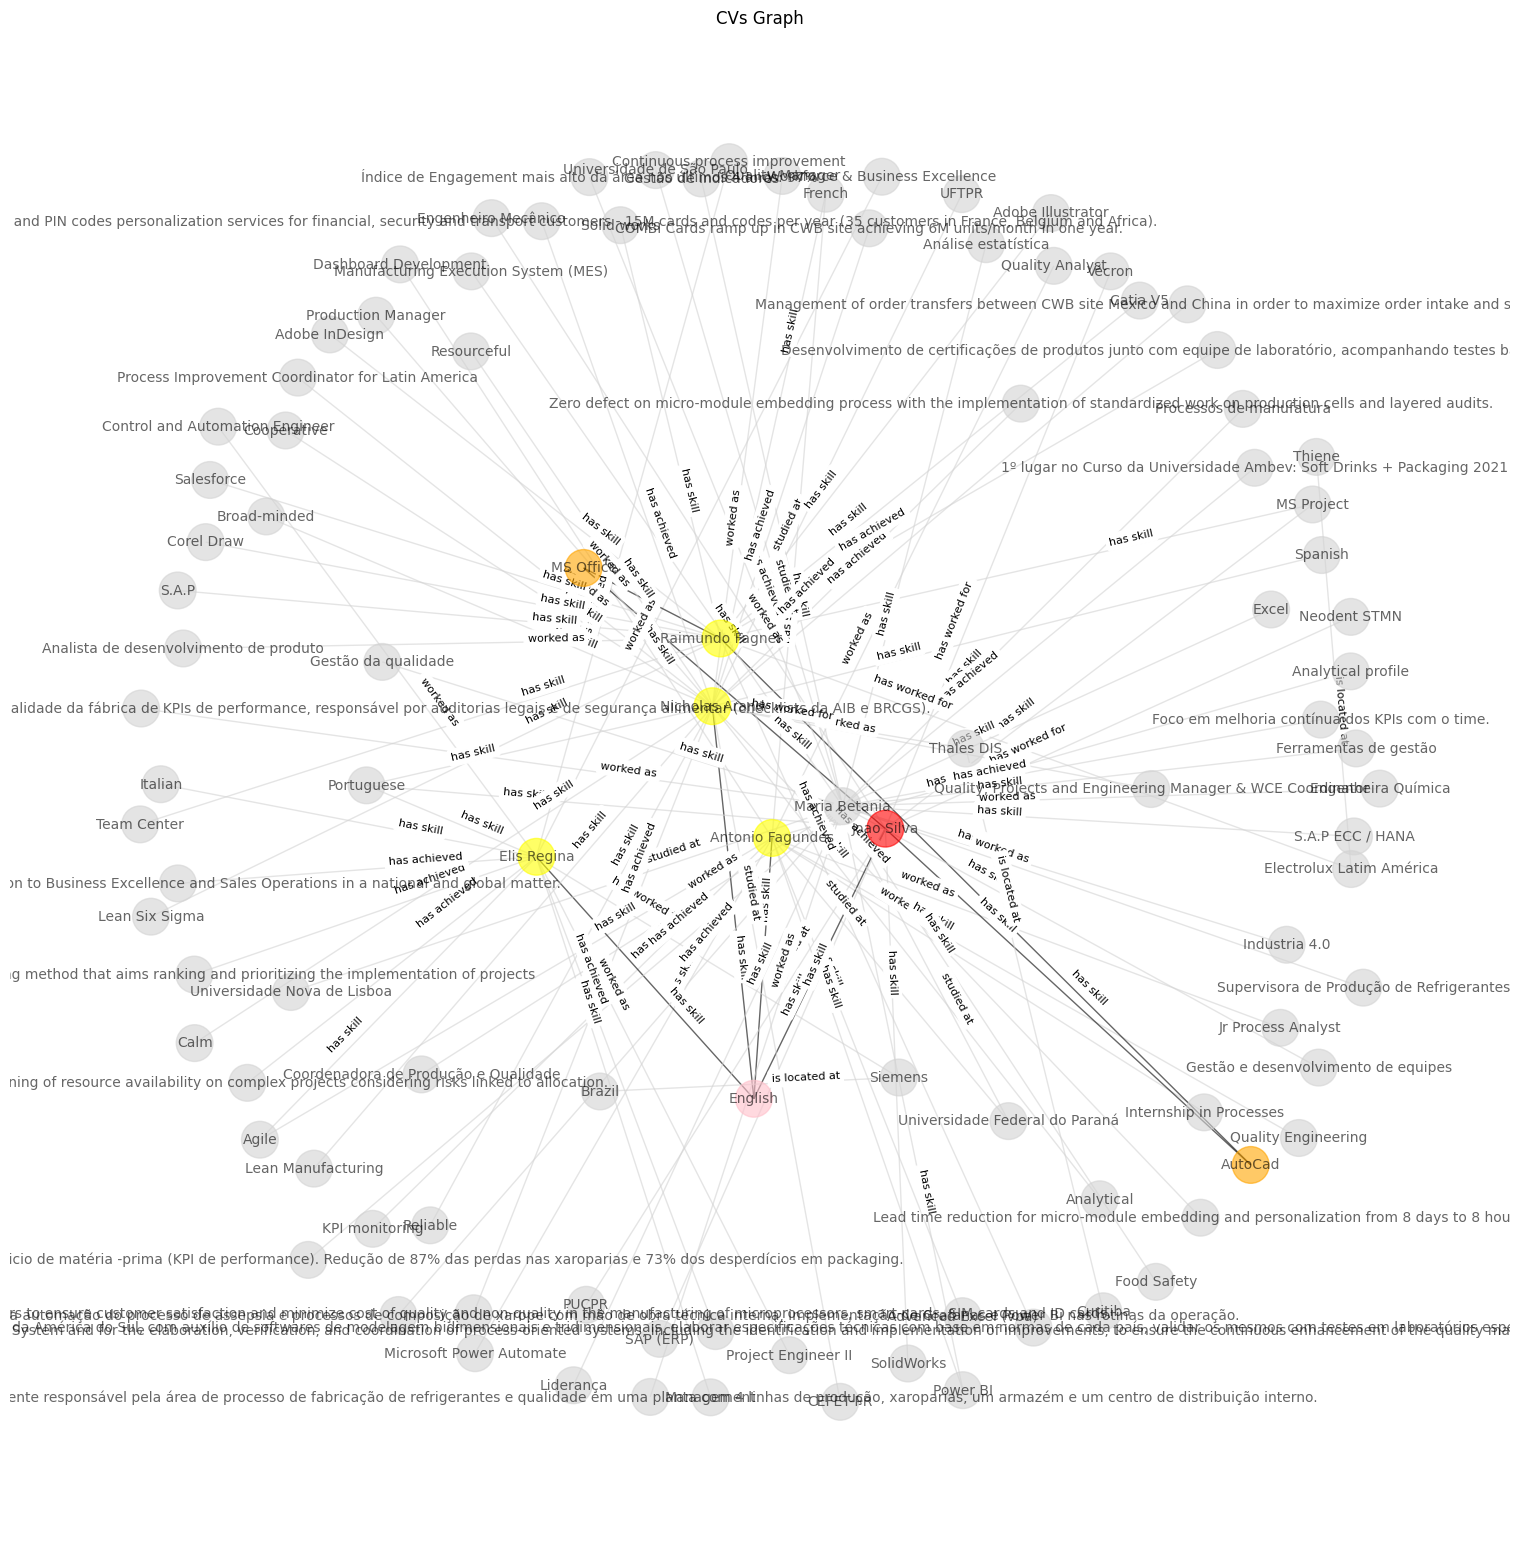

In [120]:
# Criação do Grafo
G = nx.Graph()
# Create nodes with atributes
for _, row in kg_relations.iterrows():
  #if node doesn't exist, create it
  if not G.has_node(row['head']):
    G.add_node(row['head'], type=row['head_type'], show=row['show_flag'])
  if not G.has_node(row['tail']):
    G.add_node(row['tail'], type=row['tail_type'], show=row['show_flag'])
#Create edges with labels
for _, row in kg_relations.iterrows():
  G.add_edge(row['head'], row['tail'], label=row['relation'], show=row['show_flag'])

# Impressão do grafo

# Definição das cores por nó
entity_color = {
  "person": "red", 
  "company": "yellow",
  "position": "green" , 
  "achievement": "lightblue" ,
  "place": "white", 
  "language": "pink", 
  "school or university": "white",
  "technology": "orange",
  "skill": "orange"
}
#Create index of colors for nodes by type
node_color = []
for node in G.nodes():
  if G.nodes[node]['type'] == 'person':
    if node == pass_list[0]:
      node_color.append('red')
    elif node in pass_list:
      node_color.append('yellow')
    else:
      node_color.append('lightgray')
  else:
    if G.nodes[node]['show'] == 1:
      node_color.append(entity_color[G.nodes[node]['type']])
    else:
      node_color.append('lightgray')

# Create index of colors for edges by label
edge_color = []
for edge in G.edges():
  if G.edges[edge]['show'] == 1:
    edge_color.append('black')
  else:
    edge_color.append('lightgray')

# Impressao
pos = nx.spring_layout(G, seed=47, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color=node_color, edge_color=edge_color, alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('CVs Graph')
plt.show()

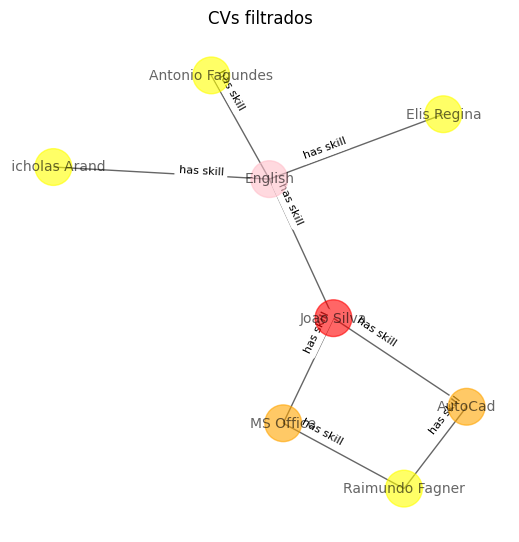

In [125]:
# Criação do Grafo
G = nx.Graph()
# Create nodes with atributes
for _, row in kg_relations[kg_relations['show_flag']==1].iterrows():
  #if node doesn't exist, create it
  if not G.has_node(row['head']):
    G.add_node(row['head'], type=row['head_type'], show=row['show_flag'])
  if not G.has_node(row['tail']):
    G.add_node(row['tail'], type=row['tail_type'], show=row['show_flag'])
#Create edges with labels
for _, row in kg_relations[kg_relations['show_flag']==1].iterrows():
  G.add_edge(row['head'], row['tail'], label=row['relation'], show=row['show_flag'])

# Impressão do grafo

# Definição das cores por nó
entity_color = {
  "person": "red", 
  "company": "yellow",
  "position": "green" , 
  "achievement": "lightblue" ,
  "place": "white", 
  "language": "pink", 
  "school or university": "white",
  "technology": "orange",
  "skill": "orange"
}
#Create index of colors for nodes by type
node_color = []
for node in G.nodes():
  if G.nodes[node]['type'] == 'person':
    if node == pass_list[0]:
      node_color.append('red')
    elif node in pass_list:
      node_color.append('yellow')
    else:
      node_color.append('lightgray')
  else:
    if G.nodes[node]['show'] == 1:
      node_color.append(entity_color[G.nodes[node]['type']])
    else:
      node_color.append('lightgray')

# Create index of colors for edges by label
edge_color = []
for edge in G.edges():
  if G.edges[edge]['show'] == 1:
    edge_color.append('black')
  else:
    edge_color.append('lightgray')

# Impressao
pos = nx.spring_layout(G, seed=47, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(5, 5))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color=node_color, edge_color=edge_color, alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('CVs filtrados')
plt.show()